### Import Libraries

In [1]:
import numpy as np
import os
import pickle
import csv
import math
from gensim.models import Word2Vec
from sklearn.utils import resample
import random
import time

random.seed(3919)

In [2]:
import pandas as pd
import re
from collections import Counter

In [3]:
from pprint import pprint
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.test.utils 
import itertools
from sklearn.utils import resample
from multiprocessing import Pool

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

### import dataset

In [ ]:
#read df phrased lemma with preprocessed text (from office PC)
df = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/df_lemma_preprocessing.pkl')

In [ ]:
df.info()

In [ ]:
all_text = " ".join(df['text_clean'])
word_count = len(re.findall(r'\w+', all_text))
print("Total number of words:", word_count)

In [127]:
#load word2vec model on entire 
model_path = '/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/wordembedding/models/model2.bin'
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [128]:
model.most_similar(positive = ['миропорядок'],topn=20)
# check for synonyms

[('полицентричный', 0.8527029156684875),
 ('формирование_полицентричного', 0.820906400680542),
 ('демократический_справедливый', 0.8150774240493774),
 ('справедливый_демократический', 0.8125821352005005),
 ('международный_система', 0.8066527843475342),
 ('многополярный', 0.805690586566925),
 ('демократический_полицентричного', 0.7952263951301575),
 ('демократический_система', 0.791087806224823),
 ('формирование_многополярный', 0.7885502576828003),
 ('объективный_процесс', 0.7861343622207642),
 ('многообразие_современный', 0.7795619964599609),
 ('отражать_культурно', 0.7786999344825745),
 ('объективно_формироваться', 0.7784688472747803),
 ('новый_мироустройство', 0.7783229351043701),
 ('однополярная', 0.7770311832427979),
 ('пятисотлетнее', 0.774179220199585),
 ('справедливый_демократичный', 0.7732346057891846),
 ('ооноцентричной', 0.7725827693939209),
 ('новый_миропорядок', 0.7700087428092957),
 ('тенденция_формирование', 0.7696325182914734)]

In [149]:
words = model.key_to_index

In [152]:
wv = [model[word]for word in words]

In [154]:
reducer = UMAP(n_components=2, metric='cosine', n_neighbors=20, min_dist=0.1)

In [155]:
reducer_wc = reducer.fit_transform(wv)

### chunk the df into 4 time frames according to presidential mandate

In [ ]:
#trasnform date into datetime
df['date'] = pd.to_datetime(df.date)
df['date'] = df['date'].dt.strftime('%Y-%m-%d')
df['date'].sort_values()

In [ ]:
# create boolean masks for each date range
mask1 = (df['date'] >= '2003-01-01') & (df['date'] <= '2008-03-02')
mask2 = (df['date'] >= '2008-03-03') & (df['date'] <= '2012-03-04')
mask3 = (df['date'] >= '2012-03-05') & (df['date'] <= '2018-03-18')
mask4 = (df['date'] >= '2018-03-19') & (df['date'] <= '2023-12-31')

In [ ]:
# create smaller dataframes using boolean indexing
t1 = df.loc[mask1] # second Putin's mandate (plus_ a couple of doc from 2003 in Lavrov's):2004-2008
t2 = df.loc[mask2] # Medvedev: 2008-2012
t3 = df.loc[mask3] # third Putin's mandate: 2012-2018
t4 = df.loc[mask4] # fourth Putin's mandate: 2018 - till present (2023)

In [ ]:
# Save the four dataframes in separate pickle files (from office)
t1.to_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t1.pkl')
t2.to_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t2.pkl')
t3.to_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t3.pkl')
t4.to_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t4.pkl')

In [5]:
# read each era from office
t1 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t1.pkl')
t2 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t2.pkl')
t3 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t3.pkl')
t4 = pd.read_pickle('/Users/adrianacupp/Desktop/GitHub/russia_lio_contestation/corpus_president_of_russia/t4.pkl')


In [6]:
# read each era from MAC
t1 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t1.pkl')
t2 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t2.pkl')
t3 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t3.pkl')
t4 = pd.read_pickle('/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/russia_lio_contestation/corpus_president_of_russia/t4.pkl')

In [7]:
#sample the 10% out of it
sample_t1 = t1.sample(frac=0.1, replace=False)
sample_t2 = t2.sample(frac=0.1, replace=False)
sample_t3 = t3.sample(frac=0.1, replace=False)
sample_t4 = t4.sample(frac=0.1, replace=False)

In [8]:
print(sample_t1.info())
print(sample_t2.info())
print(sample_t3.info())
print(sample_t4.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 707 to 626
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           104 non-null    object
 1   url            104 non-null    object
 2   title          104 non-null    object
 3   speaker        104 non-null    object
 4   text           104 non-null    object
 5   text_clean     104 non-null    object
 6   word_count     104 non-null    int64 
 7   lemma          104 non-null    object
 8   phrased_lemma  104 non-null    object
dtypes: int64(1), object(8)
memory usage: 8.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 2105 to 1183
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           113 non-null    object
 1   url            113 non-null    object
 2   title          113 non-null    object
 3   speaker        113 non-null    object


### Codebook

In [9]:
eurasianism = ['евразия',
               'русский_мир', 
               'цивилизация', 
               'доминирование_запад', 
               'правило_запад',
               'запад', 
               'гегемония',
               'исторический_ревизионизм']

westphalianism = [ 'оон',
                  'великодержавность',
                  'статус',
                  'принцип_суверенный',
                  'международное_право',
                  'демократический_справедливый',
                  'международное_право_норма', 
                  'ооноцентричной',
                  'суверенность']

In [10]:
security_concerns = [ 'национальная_безопасность',
                     'противовес',
                     'дестабилизация',
                     'нато',
                     'угроза',
                     'подменить_международное_право',
                     'порядок_основать', 
                     'однополярная',
                     'новый_мироустройство', 
                     'расширяться_восток',
                     'однополярный_модель', 
                     'однополярный', 
                     'военный_инфраструктура']

multipolarism = ['многополярный', 
                 'партнёрство', 
                 'сотрудничество', 
                 'полицентричный',
                 'формирование_многополярный', 
                 'формирование_полицентричного', 
                 'демократический_полицентричного']

In [14]:
target_word = 'миропорядок'
for word in multipolarism:
    similarity_score = model.similarity(target_word, word)
    print(f"Similarity between '{target_word}' and '{word}': {similarity_score}")

Similarity between 'миропорядок' and 'многополярный': 0.8056905269622803
Similarity between 'миропорядок' and 'партнёрство': 0.38575419783592224
Similarity between 'миропорядок' and 'сотрудничество': 0.36429068446159363
Similarity between 'миропорядок' and 'полицентричный': 0.8527029752731323
Similarity between 'миропорядок' and 'формирование_многополярный': 0.7885503768920898
Similarity between 'миропорядок' and 'формирование_полицентричного': 0.820906400680542
Similarity between 'миропорядок' and 'демократический_полицентричного': 0.7952264547348022


### transform data in list of lists

In [11]:
# 10% SAMPLE
#transform each timeframe df in a list
era1 = sample_t1['phrased_lemma'].tolist()
era2 = sample_t2['phrased_lemma'].tolist()
era3 = sample_t3['phrased_lemma'].tolist()
era4 = sample_t4['phrased_lemma'].tolist()

In [12]:
len(era1)

104

In [13]:
list_of_lists = []
list_of_lists.append(era1)
list_of_lists.append(era2)
list_of_lists.append(era3)
list_of_lists.append(era4)

In [14]:
len(list_of_lists)

4

In [25]:
word_freqs =  [Counter(sent) for sent in list_of_lists[0]]
# print the top 10 most common words in the first document
print(word_freqs[0].most_common(10))

[('день', 3), ('октябрь', 3), ('москва', 2), ('государственный', 2), ('независимость', 2), ('новый', 2), ('переговорный_процесс', 2), ('специальный_рабочий', 2), ('группа', 2), ('каспий', 2)]


### count target_word

In [15]:
word_count = 0
for doc in t4['phrased_lemma']:
    if 'миропорядок' in doc:
        word_count += doc.count('миропорядок')

print(f"'миропорядок' appears {word_count} times in the 'phrased_lemma' column of the DataFrame.")

'миропорядок' appears 273 times in the 'phrased_lemma' column of the DataFrame.


In [16]:
#sample_t4
word_count = 0
for doc in sample_t4['phrased_lemma']:
    if 'миропорядок' in doc:
        word_count += doc.count('миропорядок')

print(f"'миропорядок' appears {word_count} times in the 'phrased_lemma' column of the DataFrame.")

'миропорядок' appears 26 times in the 'phrased_lemma' column of the DataFrame.


In [17]:
sample_t4['phrased_lemma'].head()

6464    [вопрос_сегодня, встречаться, грузоперевозчика...
5709    [уважаемые_дама, господь_рад, встреча_проводит...
6099    [рад_видеть, слышать, насыщенный_программа, об...
4676    [добрый_день, уважаемые_коллега, сегодня_повес...
6603    [уважаемые_дама, господь_завершить, продолжите...
Name: phrased_lemma, dtype: object

### Iterating over lists of sentences by era to do era-by-era word2vec modeling

In [40]:
n_bootstraps = 2
target_word = 'миропорядок'
vector_size=100 
min_count=2 
sg=1 
hs=0 
negative=5 
window=30 
workers=4 
epochs=100

In [45]:
#print the progress for each run
def word_embedding(list_of_lists, target_word, eurasianism, westphalianism, security_concerns, multipolarism, 
                   n_bootstraps=n_bootstraps, vector_size=vector_size, min_count=min_count, sg=sg, 
                   hs=hs, negative=negative, window=window, workers=workers, epochs=epochs):
    
    scores = {}
    
    for j in range(len(list_of_lists)):
        era_scores = {}
        start_time = time.time()
        for k in range(n_bootstraps):
            sentence_samples = resample(list_of_lists[j])
            model = Word2Vec(
                sentence_samples,
                vector_size=vector_size, 
                min_count=min_count, 
                sg=sg, 
                hs=hs, 
                negative=negative, 
                window=window, 
                workers=workers,
                epochs=epochs
            )

            eurasianism_scores = []
            westphalianism_scores = []
            security_concerns_scores = []
            multipolarism_scores = []

            for word in eurasianism:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    eurasianism_scores.append(similarity_score)
                else:
                    eurasianism_scores.append('NA')

            for word in westphalianism:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    westphalianism_scores.append(similarity_score)
                else:
                    westphalianism_scores.append('NA')

            for word in security_concerns:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    security_concerns_scores.append(similarity_score)
                else:
                    security_concerns_scores.append('NA')

            for word in multipolarism:
                if word in model.wv:
                    similarity_score = model.wv.similarity(target_word, word)
                    multipolarism_scores.append(similarity_score)
                else:
                    multipolarism_scores.append('NA')

            era_scores[k] = {
                'eurasianism': eurasianism_scores,
                'westphalianism': westphalianism_scores,
                'security_concerns': security_concerns_scores,
                'multipolarism': multipolarism_scores
            }
            
            # Print progress for each run
            print("Finished with run %d out of %d for era %d" % (k+1, n_bootstraps, j+1))
            
        scores[j] = era_scores
        
        end_time = time.time()
        era = j+1
        print("Finished with era %d in %.2f seconds." % (era, end_time-start_time))
        
    print("*******Finished with all eras.*******")
    
    return scores

In [46]:
scores = word_embedding(list_of_lists, target_word, eurasianism, westphalianism, security_concerns, multipolarism, 
               n_bootstraps = n_bootstraps, vector_size=vector_size, min_count=min_count, sg=sg, hs=hs, negative=negative, 
               window=window, workers=workers, epochs=epochs)

Finished with run 1 out of 2 for era 1
Finished with run 2 out of 2 for era 1
Finished with era 1 in 134.01 seconds.


KeyboardInterrupt: 

In [24]:
scores

{0: {0: {'eurasianism': [0.26043946,
    'NA',
    0.21788144,
    'NA',
    'NA',
    0.06992233,
    'NA',
    'NA'],
   'westphalianism': [0.24910375,
    'NA',
    0.10933363,
    'NA',
    0.34751895,
    0.6953327,
    'NA',
    'NA',
    0.14674398],
   'security_concerns': ['NA',
    'NA',
    0.17685989,
    0.07599416,
    0.118990004,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA'],
   'multipolarism': [0.4836083,
    0.023254517,
    0.027282145,
    'NA',
    'NA',
    'NA',
    'NA']}},
 1: {0: {'eurasianism': [0.14096385,
    0.2309123,
    0.10528213,
    'NA',
    'NA',
    0.377352,
    'NA',
    'NA'],
   'westphalianism': [0.1504083,
    'NA',
    0.30242664,
    'NA',
    0.36040473,
    'NA',
    'NA',
    'NA',
    0.29773146],
   'security_concerns': ['NA',
    'NA',
    0.30610338,
    0.15080869,
    0.1002595,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA'],
   'multipolarism': [0.2250882,
    0.

In [25]:
# initialize empty dictionary to store the scores
stat_types = {}

# loop through each target word and its scores
for target_word, target_scores in scores.items():

    # initialize empty dictionary to store the scores for this target word
    target_stat_types = {}

    # loop through each era and its scores for this target word
    for era, era_scores in target_scores.items():

        # initialize empty dictionary to store the scores for this era
        era_stat_types = {}

        # loop through each statistical type and its score for this era
        for stat_type, score in era_scores.items():
            era_stat_types[stat_type] = score

        # add the scores for this era to the scores for this target word
        target_stat_types[era] = era_stat_types

    # add the scores for this target word to the overall dictionary of scores
    stat_types[target_word] = target_stat_types


In [26]:
stat_types

{0: {0: {'eurasianism': [0.26043946,
    'NA',
    0.21788144,
    'NA',
    'NA',
    0.06992233,
    'NA',
    'NA'],
   'westphalianism': [0.24910375,
    'NA',
    0.10933363,
    'NA',
    0.34751895,
    0.6953327,
    'NA',
    'NA',
    0.14674398],
   'security_concerns': ['NA',
    'NA',
    0.17685989,
    0.07599416,
    0.118990004,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA'],
   'multipolarism': [0.4836083,
    0.023254517,
    0.027282145,
    'NA',
    'NA',
    'NA',
    'NA']}},
 1: {0: {'eurasianism': [0.14096385,
    0.2309123,
    0.10528213,
    'NA',
    'NA',
    0.377352,
    'NA',
    'NA'],
   'westphalianism': [0.1504083,
    'NA',
    0.30242664,
    'NA',
    0.36040473,
    'NA',
    'NA',
    'NA',
    0.29773146],
   'security_concerns': ['NA',
    'NA',
    0.30610338,
    0.15080869,
    0.1002595,
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA',
    'NA'],
   'multipolarism': [0.2250882,
    0.

In [81]:
### Saving the model
with open('models/naive_model_test.pkl', 'wb') as f:
    pickle.dump(stat_types, f)

In [83]:
### Loading the model
with open('models/naive_model_test.pkl', 'rb') as f:
    stat_types = pickle.load(f)

get the mean of the bootstrap sample for vectors of sigle word and for vectors of all words from the corpus

In [66]:
#how the dict is structured
for key in stat_types.keys():
    print(key)
    for subkey in stat_types[key].keys():
       print(subkey)
       for subsubkey in stat_types[key][subkey].keys():
            print(subsubkey)


0
0
eurasianism
westphalianism
security_concerns
multipolarism
1
0
eurasianism
westphalianism
security_concerns
multipolarism
2
0
eurasianism
westphalianism
security_concerns
multipolarism
3
0
eurasianism
westphalianism
security_concerns
multipolarism


In [29]:
means_wCI = []

In [81]:
for era in stat_types:
   for target_word in stat_types[era]:
      print(f"Target word: {target_word}, Era: {era}")
      for topic in stat_types[era][target_word]:
         scores = stat_types[era][target_word][topic]
         non_na_scores = [score for score in scores if score != 'NA']
         if non_na_scores:
                print(f"Topic: {topic}, Non-NA Scores: {non_na_scores}")


Target word: 0, Era: 0
Topic: eurasianism, Non-NA Scores: [0.23611195, 0.3017056, 0.12120998]
Topic: westphalianism, Non-NA Scores: [0.301473, 0.1782802, 0.086803794]
Topic: security_concerns, Non-NA Scores: [0.2230665, 0.11874799, 0.27350312]
Topic: multipolarism, Non-NA Scores: [0.32616457, 0.20784695, 0.16787864]
Target word: 0, Era: 1
Topic: eurasianism, Non-NA Scores: [0.27415803, 0.20329495, 0.1403791]
Topic: westphalianism, Non-NA Scores: [0.2827706, 0.2041224, 0.39546254]
Topic: security_concerns, Non-NA Scores: [0.122643426, 0.06453786, 0.051859178, 0.08714982, 0.1190715, 0.14253482]
Topic: multipolarism, Non-NA Scores: [0.46177483, 0.17690699, 0.28429976, 0.27746]
Target word: 0, Era: 2
Topic: eurasianism, Non-NA Scores: [0.15980461, 0.14760372, 0.18156637, 0.10109056, 0.30702153]
Topic: westphalianism, Non-NA Scores: [0.3314321, 0.076466344, 0.3421914, 0.47189277]
Topic: security_concerns, Non-NA Scores: [0.1911688, 0.113584094, 0.18712348, 0.21596834, 0.15309006, 0.08008233

In [30]:
## calculate means for nonNA vectors and CI
for era in stat_types:
    stats = []
    for boostrap in stat_types[era]:
        for topic in stat_types[era][boostrap]:
            scores = stat_types[era][boostrap][topic]
            non_na_scores = [score for score in scores if score != 'NA' and score is not None] # filter out None values
            test = np.asarray(non_na_scores)
            if len(test) > 0: # check if there are any non-NA values
                test_mean = test.mean()
                test_error = 1.95 * (test.std() / math.sqrt(len(non_na_scores)))
                test_ci = (test_mean - test_error, test_mean + test_error)
                test_stats = test_mean, test_ci
                stats.append(test_stats)
    means_wCI.append(stats)


In [31]:
means_wCI 
#The output of the code would be a list of statistics 
# (means and confidence intervals) for each combination of target word and ideology

[[(0.18274774, (0.0908239607191216, 0.274671512427317)),
  (0.3096066, (0.12646597076007013, 0.49274725269726627)),
  (0.123948015, (0.0774204500042374, 0.17047558054099726)),
  (0.17804831, (-0.06521019006186132, 0.4213068153899253))],
 [(0.21362758, (0.11122565120458604, 0.3160295024514198)),
  (0.2777428, (0.20213171150535347, 0.353353894688189)),
  (0.18572386, (0.08711550335556201, 0.28433220882743665)),
  (0.25290447, (0.15954374596476556, 0.34626520350575446))],
 [(0.21574701, (0.17532786866649985, 0.2561661587096751)),
  (0.11436309, (0.06467111371457576, 0.1640550646930933)),
  (0.19613728, (0.16970332602049448, 0.22257123252366445)),
  (0.37770444, (0.1937449350953102, 0.5616639479994774))],
 [(0.32838607, (0.19393829657251832, 0.4628338401157141)),
  (0.3901871, (0.2785640232100824, 0.5018102057442329)),
  (0.2627686, (0.15566985699105934, 0.36986733583044334)),
  (0.23969941, (0.0944104716181755, 0.38498834520578384))]]

In [126]:
# define the file path
file_path = "models/means_wCI.pkl"

# save the object to file
with open(file_path, 'wb') as f:
    pickle.dump(means_wCI, f)


### plot each concept cos sim evolution over time

In [ ]:
# load the object from file
with open("models/means_wCI.pkl", 'rb') as f:
    means_wCI = pickle.load(f)


#### eurasianism

In [37]:
eurasianism_means = [era[0][0] for era in means_wCI]

In [38]:
eurasianism_means

[0.18274774, 0.21362758, 0.21574701, 0.32838607]

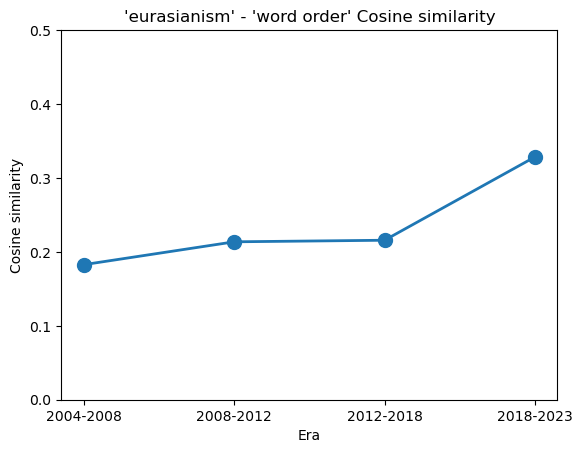

In [39]:
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(eurasianism_means, marker="o", markersize=10, linewidth=2)
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'eurasianism' - 'word order' Cosine similarity")
plt.ylim(0.0, 0.5)
plt.show()

#### westphalianism

In [108]:
westphalianism_means = [era[1][0] for era in means_wCI]

In [109]:
westphalianism_means

[0.18885233, 0.29411852, 0.30549568, 0.23461019]

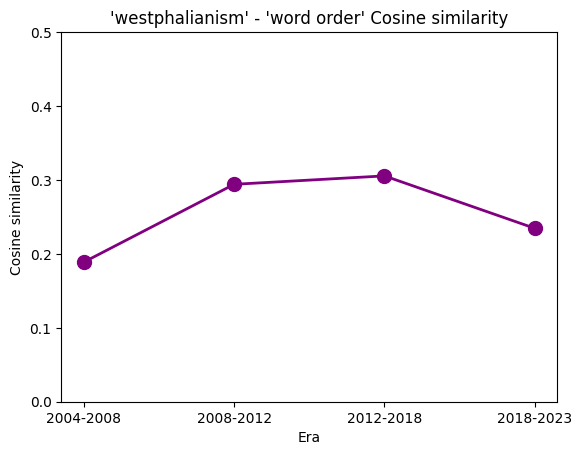

In [125]:
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(westphalianism_means, marker="o", markersize=10, linewidth=2,color='purple')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'westphalianism' - 'word order' Cosine similarity")
plt.ylim(0.0, 0.5)
plt.show()

#### security_concerns

In [112]:
sec_con_means = [era[2][0] for era in means_wCI]

In [113]:
sec_con_means

[0.20510586, 0.0979661, 0.15915814, 0.2635398]

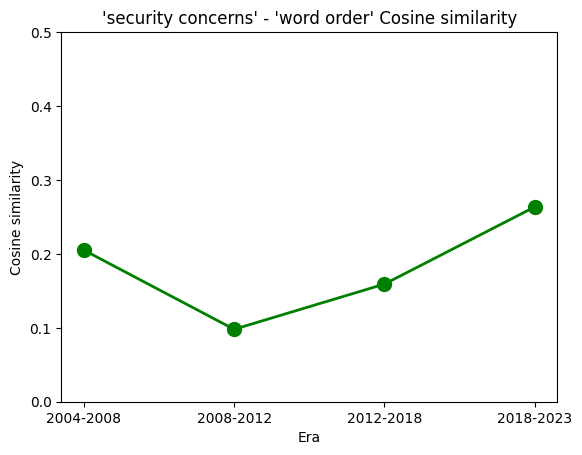

In [124]:
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(sec_con_means, marker="o", markersize=10, linewidth=2,color='green')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'security concerns' - 'word order' Cosine similarity")
plt.ylim(0.0, 0.5)
plt.show()

#### multipolarism

In [119]:
multipolarism_means = [era[3][0] for era in means_wCI]

In [120]:
multipolarism_means

[0.23396339, 0.3001104, 0.3184208, 0.2784261]

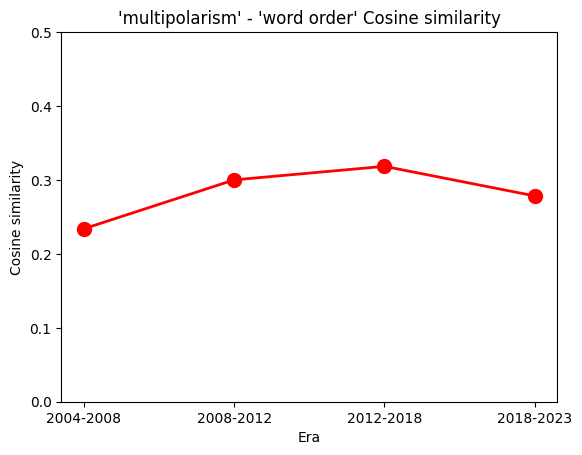

In [123]:
# Define x-axis labels
x_labels = ["2004-2008", "2008-2012", "2012-2018", "2018-2023"]
y_limits = [0.2, 0.5]
# Plot cosine similarity over time
plt.plot(multipolarism_means, marker="o", markersize=10, linewidth=2,color='red')
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("Era")
plt.ylabel("Cosine similarity")
plt.title("'multipolarism' - 'word order' Cosine similarity")
plt.ylim(0.0, 0.5)
plt.show()